# Transitions from hypergraphs to simplicial complexes

This code was used for the analysis presented in  
"Do higher-order interactions promote synchronization?"  
by Yuanzhao Zhang, Maxime Lucas, and Federico Battiston

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sb
from matplotlib.colors import to_rgb
from tqdm import tqdm

import xgi
from utils import (
    compute_eigenvalues_multi,
    shuffle_hyperedges,
    flag_complex_d2,
)

sb.set_theme(style="ticks", context="paper")

fig_dir = "figures/"
results_dir = "results/"
data_dir = "data/"

Path(fig_dir).mkdir(parents=True, exist_ok=True)
Path(results_dir).mkdir(parents=True, exist_ok=True)

## Brain datasets

Calculate lambda_2 vs alpha for a hypergraph obtained by shuffling an maximum simplicial complex with probability p (real brain networks)

In [2]:
data_folder = "data/"
data_files = os.listdir(data_folder)
data_files = [
    dat
    for dat in data_files
    if "xgi" not in dat and "Store" not in dat and ".txt" not in dat
]
data_names = [".".join(data_file.split(".")[:-1]) for data_file in data_files]
data_files

['bn-macaque-rhesus_brain_1.edges',
 'bn-macaque-rhesus_cerebral-cortex_1.edges',
 'p.pacificus_neural.synaptic_1.graphml',
 'bn-cat-mixed-species_brain_1.edges',
 'c.elegans.herm_pharynx_1.graphml',
 'c.elegans_neural.male_1.graphml']

### Single dataset

In [4]:
# import brain network
k = 5
data_file = data_files[k]

net_name = data_names[k]
ext = data_file.split(".")[-1]
print(data_file)

if ext == "edges":
    G = nx.read_edgelist(f"{data_folder}{data_file}")
elif ext == "graphml":
    G = nx.read_graphml(f"{data_folder}{data_file}")
    G = nx.Graph(G)
else: 
    raise ValueError("Unknown data format")
    
G = nx.convert_node_labels_to_integers(G)

N = G.number_of_nodes()
P = [0, 0.2, 0.4, 0.6, 0.8, 1]

n_p = len(P)  # number of p values
n_rep = 10  # number of independent realizations

alphas = np.arange(0, 1.01, 0.05)

lyaps_arr = np.zeros((n_p, n_rep, len(alphas), N))

for i in tqdm(range(n_p)):
    for j in range(n_rep):

        # generate maximum simplicial complex
        MSC = flag_complex_d2(G)
        H = shuffle_hyperedges(MSC, order=2, p=P[i])

        for ii, alpha in enumerate(alphas):
            lyap_multi = compute_eigenvalues_multi(
                H, orders=[1, 2], weights=[1 - alpha, alpha]
            )

            lyap_multi = np.sort(lyap_multi)[::-1]
            lyaps_arr[i, j, ii, :] = lyap_multi


print(H)
np.save(f"{results_dir}{net_name}.npy", lyaps_arr)

c.elegans_neural.male_1.graphml


100%|███████████████████████████████████████████████████████████| 6/6 [07:06<00:00, 71.10s/it]

Unnamed Hypergraph with 272 nodes and 12970 hyperedges


Plot lambda_2 vs alpha

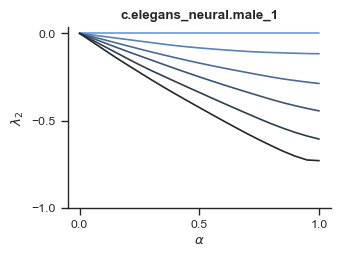

In [6]:
k = 5
net_name = data_names[k]

P = [0, 0.2, 0.4, 0.6, 0.8, 1]
n_p = len(P)  # number of p values

alphas = np.arange(0, 1.01, 0.05)

lyaps_arr = np.load(f"{results_dir}{net_name}.npy", allow_pickle=True)

fig, ax = plt.subplots(figsize=(3.4, 2.35))

palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

for i in range(n_p):
    ax.plot(alphas, np.mean(lyaps_arr[i, :, :, 1], axis=0), label=f"$p={P[i]:.0f}$")

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_yticks([-0.0, -0.5, -1])
ax.set_xticks([0, 0.5, 1])

# ax.legend([r'$p_s = 0.0$', r'$p_s = 0.2$', r'$p_s = 0.4$', r'$p_s = 0.6$', r'$p_s = 0.8$', r'$p_s = 1.0$'],
#           loc='lower left', frameon=False, prop={'size':10}, ncol=1) #, bbox_to_anchor=(1.1, 1.05)

# xvals = [0.9] * 12
# labelLines(plt.gca().get_lines(), align=True, xvals=xvals, yoffsets=-0.035)
ax.set_title(net_name, weight="bold")
sb.despine()

fig_name = f"{net_name}"

plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()

### All datasets - Fig 5

In [7]:
data_names

['bn-macaque-rhesus_brain_1',
 'bn-macaque-rhesus_cerebral-cortex_1',
 'p.pacificus_neural.synaptic_1',
 'bn-cat-mixed-species_brain_1',
 'c.elegans.herm_pharynx_1',
 'c.elegans_neural.male_1']

In [8]:
titles = [
    "Macaque brain",
    "Macaque cerebral cortex",
    "P. Pacificus",
    "Cat brain",
    "C. elegans anterior",
    "C. elegans posterior",
]

idx = [2, 5, 4, 1, 0, 3]

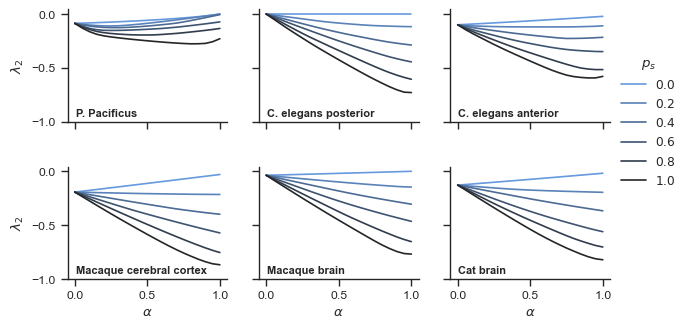

In [9]:
palette = sb.dark_palette("#69d", reverse=True, n_colors=len(P))
sb.set_palette(palette)
#idx = [4, 3, 7, 6, 2, 0, 1, 5]
idx = [2, 5, 4, 1, 0, 3]

n_cols = 3

fig, axs = plt.subplots(2, n_cols, figsize=(7, 3.5), sharex=True, sharey=True)

for kk, data_file in enumerate(np.array(data_files)[idx]):
    
    try: 
        
        ax = axs[kk // n_cols, kk % n_cols]
               
        net_name = ".".join(data_file.split(".")[:-1])
        title = np.array(titles)[idx][kk]
            
        lyaps_HG = np.load(f"{results_dir}{net_name}.npy", allow_pickle=True)

        for i in range(n_p):
            ax.plot(alphas, np.mean(lyaps_HG[i, :, :, 1], axis=0), label=f"${P[i]:.1f}$")
        
        #ax.set_title(f"{title}", weight="bold", fontsize="small")
        
        ax.text(0.05, 0.05, title,  weight="bold", fontsize="small", transform=ax.transAxes)
        
    except Exception as e: 
        print(net_name, "not working", e)
        pass
    
plt.subplots_adjust(wspace=0.45, hspace=0.4)

axs[0,0].set_ylabel(r"$\lambda_2$")
axs[1,0].set_ylabel(r"$\lambda_2$")

axs[1,0].set_xlabel(r"$\alpha$")
axs[1,1].set_xlabel(r"$\alpha$")
axs[1,-1].set_xlabel(r"$\alpha$")
axs[1,-1].set_xticks([0, 0.5, 1])
axs[1,-1].set_yticks([0, -0.5, -1])

axs[0,-1].legend(title=r"$p_s$",
                loc="center left", bbox_to_anchor=(1, -0), frameon=False)



plt.subplots_adjust(wspace=0.2)                
sb.despine()

fig_name = f"figure_5_v2" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

#plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

### All datasets - Fig 6

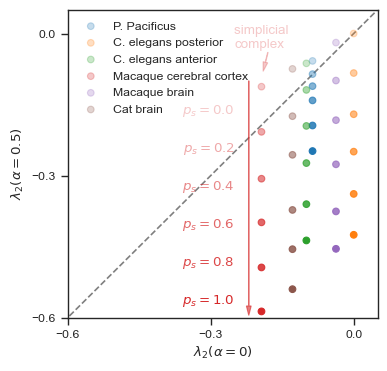

In [10]:
palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette("tab10")

sz = 4
fig, ax = plt.subplots(figsize=(sz, sz))


def scatter(x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    ax.scatter(x, y, c=color, **kwarg)


alpha_arr = [0.25, 0.4, 0.55, 0.7, 0.85, 1]

for i, file_name in enumerate(np.array(data_names)[idx]):
    try:
        lyaps_arr = np.load(f"{results_dir}{file_name}.npy", allow_pickle=True)
        scatter(
            np.mean(lyaps_arr[:, :, 0, 1], axis=1),
            np.mean(lyaps_arr[:, :, 10, 1], axis=1),
            color=f"C{i}",
            alpha_arr=alpha_arr,
            label=np.array(titles)[idx][i],
        )
    except:
        print(f"{i}, {file_name} not computed yet")

plt.plot([-1, 0.05], [-1, 0.05], "--", color="black", alpha=0.5, zorder=-2)

# annotations
prop_arrow = {"length_includes_head": True, "head_width": 0.01, "head_length": 0.02}

for i, opa in enumerate(alpha_arr):
    plt.text(
        -0.25,
        -0.17 - i * 0.08,
        f"$p_s = {P[i]:.1f}$",
        alpha=opa,
        color=f"C3",
        ha="right",
    )
plt.arrow(-0.22, -0.1, 0, -0.495, color=f"C3", alpha=0.6, **prop_arrow)

plt.text(-0.25, -0.03, "simplicial \ncomplex", alpha=0.25, ha="left", color=f"C3")
plt.arrow(-0.18, -0.04, -0.01, -0.04, color=f"C3", alpha=0.25, **prop_arrow)

ax.legend(loc="upper left", frameon=False)

plt.xlim([-0.6, 0.05])
plt.ylim([-0.6, 0.05])
ax.set_yticks([-0.0, -0.3, -0.6])
ax.set_xticks([-0.0, -0.3, -0.6])
ax.set_xlabel(r"$\lambda_2(\alpha=0)$")
ax.set_ylabel(r"$\lambda_2(\alpha=0.5)$")

fig_name = f"figure_6_datasets_summary"

plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")


## Synthetic networks

Calculate lambda_2 vs alpha for a hypergraph obtained by shuffling an maximum simplicial complex with probability p (synthetic networks) 

### Generate single BA

In [278]:
N = 100
M = 10

P = [0, 0.2, 0.4, 0.6, 0.8, 1]

n_p = len(P)  # number of p values
n_rep = 100  # number of independent realizations

alphas = np.arange(0, 1.01, 0.05)

lyaps_arr = np.zeros((n_p, n_rep, len(alphas), N))

# generate BA graphs:
# A graph of N nodes is grown by attaching new nodes each with m edges
# that are preferentially attached to existing nodes with high degree.
G = nx.barabasi_albert_graph(N, M)

for i in tqdm(range(n_p)):
    for j in range(n_rep):

        # generate maximum simplicial complex
        MSC = flag_complex_d2(G)
        H = shuffle_hyperedges(MSC, order=2, p=P[i])

        for ii, alpha in enumerate(alphas):
            lyap_multi = compute_eigenvalues_multi(
                H, orders=[1, 2], weights=[1 - alpha, alpha]
            )

            lyap_multi = np.sort(lyap_multi)[::-1]
            lyaps_arr[i, j, ii, :] = lyap_multi

np.save(f"{results_dir}barabasi_albert_{N}_{M}.npy", lyaps_arr)

100%|███████████████████████████████████████████████████████████| 6/6 [07:36<00:00, 76.00s/it]


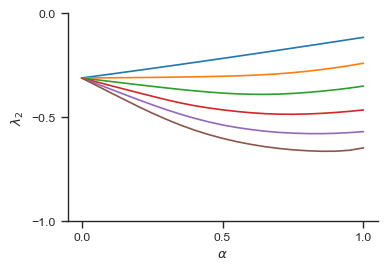

In [280]:
file_name = f"barabasi_albert_{N}_{M}"

P = [0, .2, .4, .6, .8, 1]
alphas = np.arange(0, 1.01, 0.05)
n_p = len(P)

lyaps_arr = np.load(f"{results_dir}{file_name}.npy", allow_pickle=True)

fig, ax = plt.subplots(figsize=(4, 2.7))

palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

for i in range(n_p): 
    ax.plot(alphas, np.mean(lyaps_arr[i,:,:,1],axis=0), label=f"$p={P[i]:.0f}$")

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_yticks([-0.0, -0.5, -1])
ax.set_xticks([0, 0.5, 1])

#ax.legend([r'$p = 0.0$', r'$p = 0.2$', r'$p = 0.4$', r'$p = 0.6$', r'$p = 0.8$', r'$p = 1.0$'], 
#           loc='lower left', frameon=False, prop={'size':9}, ncol=1) #, bbox_to_anchor=(1.1, 1.05)

sb.despine()

#plt.savefig(f"{file_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()

### Generate single WS

In [274]:
N = 100
M = 40

P = [0, 0.2, 0.4, 0.6, 0.8, 1]

n_p = len(P)  # number of p values
n_rep = 10  # number of independent realizations
prob = 0.15

alphas = np.arange(0, 1.01, 0.05)

lyaps_arr = np.zeros((n_p, n_rep, len(alphas), N))

# generate SW graphs:
G = nx.watts_strogatz_graph(N, M, prob)

for i in tqdm(range(n_p)):
    for j in range(n_rep):

        # generate maximum simplicial complex
        MSC = flag_complex_d2(G)
        H = shuffle_hyperedges(MSC, order=2, p=P[i])

        for ii, alpha in enumerate(alphas):
            lyap_multi = compute_eigenvalues_multi(
                H, orders=[1, 2], weights=[1 - alpha, alpha]
            )

            lyap_multi = np.sort(lyap_multi)[::-1]
            lyaps_arr[i, j, ii, :] = lyap_multi

np.save(f"{results_dir}watts_strogatz_{N}_{M}.npy", lyaps_arr)

100%|███████████████████████████████████████████████████████████| 6/6 [08:51<00:00, 88.60s/it]


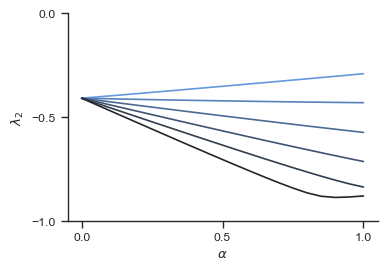

In [275]:
file_name = f"watts_strogatz_{N}_{M}"

P = [0, .2, .4, .6, .8, 1]
alphas = np.arange(0, 1.01, 0.05)
n_p = len(P)

lyaps_arr = np.load(f"{results_dir}{file_name}.npy", allow_pickle=True)

fig, ax = plt.subplots(figsize=(4, 2.7))

palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

for i in range(n_p): 
    ax.plot(alphas, np.mean(lyaps_arr[i,:,:,1],axis=0), label=f"$p={P[i]:.0f}$")

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_yticks([-0.0, -0.5, -1])
ax.set_xticks([0, 0.5, 1])

#ax.legend([r'$p = 0.0$', r'$p = 0.2$', r'$p = 0.4$', r'$p = 0.6$', r'$p = 0.8$', r'$p = 1.0$'], 
#           loc='lower left', frameon=False, prop={'size':9}, ncol=1) #, bbox_to_anchor=(1.1, 1.05)

sb.despine()

#plt.savefig(f"{file_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()

### All structures - Fig S6

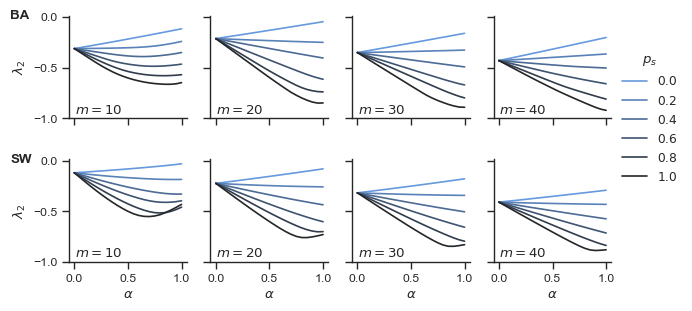

In [341]:
file_names = [
    f"barabasi_albert_100_10",
    f"barabasi_albert_100_20",
    f"barabasi_albert_100_30",
    f"barabasi_albert_100_40",
    f"watts_strogatz_100_10",
    f"watts_strogatz_100_20",
    f"watts_strogatz_100_30",
    f"watts_strogatz_100_40",
]

titles = [
    "BA, $m = 10$",
    "BA, $m = 20$",
    "BA, $m = 30$",
    "BA, $m = 40$",
    "SW, $m = 10$",
    "SW, $m = 20$",
    "SW, $m = 30$",
    "SW, $m = 40$",
]

palette = sb.dark_palette("#69d", reverse=True, n_colors=len(P))
sb.set_palette(palette)
# idx = [4, 3, 7, 6, 2, 0, 1, 5]
# idx = [2, 5, 4, 1, 0, 3]

n_cols = 4

fig, axs = plt.subplots(2, n_cols, figsize=(7, 3.2), sharex=True, sharey=True)

for kk, file_name in enumerate(file_names):

    try:

        ax = axs[kk // n_cols, kk % n_cols]
        title = f"$m = {file_name.split('_')[-1]}$"

        lyaps_HG = np.load(f"{results_dir}{file_name}.npy", allow_pickle=True)

        for i in range(n_p):
            ax.plot(
                alphas, np.mean(lyaps_HG[i, :, :, 1], axis=0), label=f"${P[i]:.1f}$"
            )

        # ax.set_title(f"{title}", weight="bold", fontsize="small")

        ax.text(
            0.05, 0.05, title, weight="bold", fontsize="medium", transform=ax.transAxes
        )

    except Exception as e:
        print(net_name, "not working", e)
        pass

plt.subplots_adjust(wspace=0.45, hspace=0.4)

axs[0, 0].set_ylabel(r"$\lambda_2$")
axs[1, 0].set_ylabel(r"$\lambda_2$")

axs[1, 0].set_xlabel(r"$\alpha$")
axs[1, 1].set_xlabel(r"$\alpha$")
axs[1, 2].set_xlabel(r"$\alpha$")
axs[1, -1].set_xlabel(r"$\alpha$")
axs[1, -1].set_xticks([0, 0.5, 1])
axs[1, -1].set_yticks([0, -0.5, -1])

axs[0, -1].legend(
    title=r"$p_s$", loc="center left", bbox_to_anchor=(1, -0), frameon=False
)


axs[0, 0].text(-0.5, 1, "BA", transform=axs[0, 0].transAxes, va="center", weight="bold")
axs[1, 0].text(-0.5, 1, "SW", transform=axs[1, 0].transAxes, va="center", weight="bold")


plt.subplots_adjust(wspace=0.2)
sb.despine()

fig_name = f"figure_S6_v2"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

# plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

### All structures - Fig S7

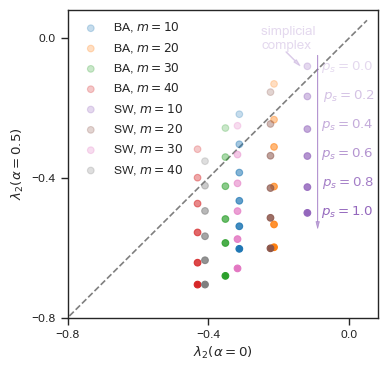

In [332]:
palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette("tab10")

sz = 4
fig, ax = plt.subplots(figsize=(sz, sz))


def scatter(x, y, color, alpha_arr, marker, **kwarg):
    r, g, b = to_rgb(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    ax.scatter(x, y, c=color, marker=marker, **kwarg)


alpha_arr = [0.25, 0.4, 0.55, 0.7, 0.85, 1]

for i, file_name in enumerate(file_names):
    try:
        lyaps_arr = np.load(f"{results_dir}{file_name}.npy", allow_pickle=True)
        
        if "BA" in file_name:
            marker = "o"
        elif "SW" in file_name:
            marker = "<"
        
        scatter(
            np.mean(lyaps_arr[:, :, 0, 1], axis=1),
            np.mean(lyaps_arr[:, :, 10, 1], axis=1),
            color=f"C{i}",
            alpha_arr=alpha_arr,
            marker=marker,
            label=titles[i],
        )
    except Exception as e:
        print(f"{i}, {file_name} not computed yet", e)

plt.plot([-1, 0.05], [-1, 0.05], "--", color="black", alpha=0.5, zorder=-2)

# annotations
prop_arrow = {"length_includes_head": True, "head_width": 0.01, "head_length": 0.02}

for i, opa in enumerate(alpha_arr):
    plt.text(
        0.07,
        -0.09- i * 0.083,
        f"$p_s = {P[i]:.1f}$",
        alpha=opa,
        color=f"C4",
        ha="right",
    )
plt.arrow(-0.09, -0.05, 0, -0.495, color=f"C4", alpha=0.6, lw=0.5, **prop_arrow)

plt.text(-0.25, -0.03, "simplicial \ncomplex", alpha=0.25, ha="left", color=f"C4")
plt.arrow(-0.18, -0.04, 0.04, -0.04, color=f"C4", alpha=0.25, **prop_arrow)

ax.legend(loc="upper left", frameon=False)

plt.xlim([-0.8, 0.08])
plt.ylim([-0.8, 0.08])
ax.set_yticks([-0.0, -0.4, -0.8])
ax.set_xticks([-0.0, -0.4, -0.8])
ax.set_xlabel(r"$\lambda_2(\alpha=0)$")
ax.set_ylabel(r"$\lambda_2(\alpha=0.5)$")

fig_name = f"figure_S7_datasets_summary"

plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")
